In [1]:
import pandas as pd
import numpy as np
# custom made functions (can be a pain to import sometimes)
import sys
sys.path.insert(0,os.path.abspath('../src/helper'))
from customPandas import *

In [2]:
# https://stackoverflow.com/questions/39125532/file-does-not-exist-in-jupyter-notebook
dataPath = os.path.abspath('../data')
fileName = 'ramen-ratings.csv'
df = pd.read_csv(f'{dataPath}/{fileName}') 

In [3]:
def cleanStars(value):
    if value == 'Unrated':
        return np.nan
    else:
        return value
df.Stars = df.Stars.apply(cleanStars) 
df[df.Stars == 'Unrated'].Stars

Series([], Name: Stars, dtype: object)

In [4]:
df = df.drop(['Review #','Top Ten'],axis=1)

In [5]:
df = df.fillna(method='ffill')

In [6]:
totalPercentageNullData(df)

,Total,Percent


In [7]:
# changing an incorrect dtype
df = df.astype({'Stars':'float64'})

In [8]:
df.describe()

,Stars
count,2580.000000
mean,3.654884
std,1.014886
min,0.000000
25%,3.250000
50%,3.750000
75%,4.250000
max,5.000000


In [9]:
Y = df['Stars']
df = df.drop(['Stars'],axis=1)

In [10]:
df

,Brand,Variety,Style,Country
0,New Touch,T's Restaurant Tantanmen,Cup,Japan
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA
3,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan
4,Ching's Secret,Singapore Curry,Pack,India
...,...,...,...,...
2575,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam
2576,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand
2577,Wai Wai,Tom Yum Shrimp,Pack,Thailand
2578,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand


In [11]:
Y

0       3.75
1       1.00
2       2.25
3       2.75
4       3.75
        ... 
2575    3.50
2576    1.00
2577    2.00
2578    2.00
2579    0.50
Name: Stars, Length: 2580, dtype: float64

In [12]:
from sklearn.preprocessing import FunctionTransformer
catFeats = df.dtypes[df.dtypes == 'object'].index.tolist()

def catFeat(df):
    return df[catFeats]

keepCat = FunctionTransformer(catFeat)

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohc',OneHotEncoder(handle_unknown='ignore')),
    ('to_dense',ToDenseTransformer()),
    ('pca',PCA(n_components=3))
    ])

In [14]:
# very usefull pipeline visualization
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ohc', OneHotEncoder(handle_unknown='ignore')),
                ('to_dense',
                 <customPandas.ToDenseTransformer object at 0x7fa21c4ab310>),
                ('pca', PCA(n_components=3))])

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
regressors = [BayesianRidge(),Lasso(), Ridge()]
# hyperparameter tuning for the Randomized Search
params = [{'regressors':[Lasso()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)]
# preprocessing pipeline
# 'pipeline__pca__n_components':range(3,5,1)
},

{'regressors':[Ridge()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)]
# preprocessing pipeline
# 'pipeline__pca__n_components':range(3,5,1)
}]
# if looking for specific parameters use the get_params methods (e.g.Lasso().get_params())

In [24]:
baseModel = Pipeline([('categories', pipeline),
                      ('regressors', regressors[0])])

In [25]:
from sklearn.model_selection import train_test_split
# split of the datasla
X_train, X_test, y_train, y_test = train_test_split(df,Y,test_size=0.33, random_state=42)

In [26]:
tunedModel = RandomizedSearchCV(baseModel,params,verbose=1,n_iter=150, cv=5,random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [27]:
BayesianRidge().get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}

In [28]:
print("model score training data: %.3f" % tunedModel.score(X_train, y_train)) 
print("model score test data: %.3f" % tunedModel.score(X_test, y_test))
print(tunedModel.best_estimator_.get_params)
tunedModel.best_params_

model score training data: 0.025
model score test data: -0.000
<bound method Pipeline.get_params of Pipeline(steps=[('categories',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing',
                                                strategy='constant')),
                                 ('ohc',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('to_dense',
                                  <customPandas.ToDenseTransformer object at 0x7fa218db1af0>),
                                 ('pca', PCA(n_components=3))])),
                ('regressors', Ridge(alpha=0.86))])>


{'regressors__alpha': 0.86, 'regressors': Ridge(alpha=0.86)}

In [29]:
y_pred = tunedModel.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
mean_absolute_error(y_test,y_pred)

0.7258020026014753

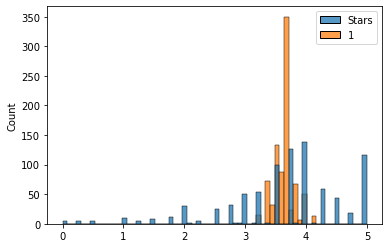

In [30]:
sns.histplot([y_test,y_pred])